## Reading the npz for summary data

In [2]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
plt.style.use("default")

## Reading the data

In [3]:
# dir = "wall implemetation\wall_size_experiment\wall_64"
dir = str(os.getcwd())
filenames = os.listdir(os.getcwd())

wall_lengths = []
folders = []

stream_list_x = []
stream_list_y = []
stream_boundaries = []

## Dictionary for storing the data

def read_summary_file(filepath):
    summary_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            # Split the line into key and value
            key, value = line.strip().split(': ')
            # Store the key-value pair in the dictionary
            summary_data[key] = float(value) if '.' in value or value.isdigit() else value
    return summary_data

simulations = []
def reading_npz(filenames, simulations, iteration = 0, alignment = True, hist = True, stream = True):
    for item in filenames:
        
        
        if item[:7] == "wall128":
            data = {"wall length": 0, "stream": 0, "histogram":0, "angle": 0, "angle_std": 0, "steps": 0, "alignment_average": 0}
            folder = dir + "/" + item
            wall_length = item.split("_")[1]
            data["wall length"] = float(wall_length)

            if stream:
                ### Loading streamplot data
                stream_data = np.load(folder + f"/stream_plot_{wall_length}_{iteration}.npz")
                stream_x = stream_data["X"]
                stream_y = stream_data["Y"]
                stream_boundaries = [stream_x, stream_y]
                data["stream"] = [stream_data[stream_data.files[2]],stream_data[stream_data.files[3]]]

            if hist:
                ### Loading histogram data
                histogram_data = np.load(folder + f"/histogram_data_{wall_length}_{iteration}.npz")
                data["histogram"] = histogram_data["hist"]

            if alignment:
                ### Loading alignment data
                alignment_data = np.load(folder + f"/alignment_{wall_length}_{iteration}.npz")
                data["angle"] = alignment_data["angles"]
                data["angle_std"] = alignment_data["std"]

            ### Loading summary data
            summary_file = folder + f"/simulation_parameters_{wall_length}.txt"
            summary_data = read_summary_file(summary_file)
            data["steps"] = summary_data['Total number of steps']
            data["alignment_average"] = summary_data['Alignment average steps']
            data["rho"] = summary_data["Density (rho)"]
            data["eta"] = summary_data["Noise/randomness (eta)"]
            data["iteration"] = iteration

            simulations.append(data)
    return simulations

for i in range(6):
    simulations = reading_npz(filenames, simulations, iteration=i, stream=False, hist = False)

len(simulations)

36

In [4]:
simulations[0]

{'wall length': 0.0,
 'stream': 0,
 'histogram': 0,
 'angle': array([ 0.57837283, -2.0973635 , -1.78969857, ..., -1.91713566,
        -1.92966633, -1.93247836]),
 'angle_std': array([ 3.16192296, -2.96926838,  2.81213913, ...,  0.58789425,
         0.59168781,  0.58577108]),
 'steps': 10000.0,
 'alignment_average': 10.0,
 'rho': 1.0,
 'eta': 0.1,
 'iteration': 0}

# Plotting the alignment

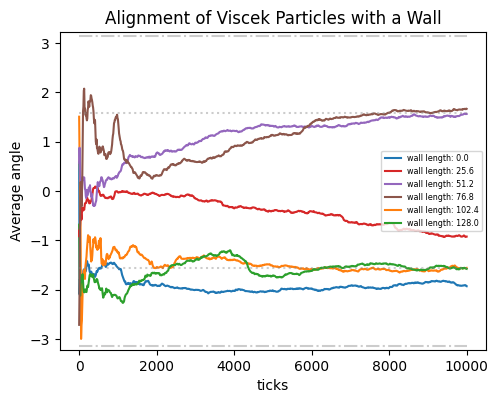

In [5]:
text_width = 5.5
fig_width = text_width
fig_height = 0.75* fig_width
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

lines = []
wall_lengths = []

iteration = 0
for simulation in simulations[6*iteration:6*(1+iteration)]:
    angle = simulation["angle"]
    steps = simulation["steps"]
    alignment_average_frames = simulation["alignment_average"]
    rho = simulation["rho"]
    eta = simulation["eta"]

    times = np.arange(0,steps +1, alignment_average_frames)
    line = ax.plot(times, angle, label = f"wall length: {simulation['wall length']:.1f}")[0]
    lines.append(line)
    wall_lengths.append(simulation["wall length"])
# Sort the lines based on wall lengths
sorted_indices = np.argsort(wall_lengths)
sorted_lines = [lines[i] for i in sorted_indices]
sorted_labels = [f"wall length: {wall_lengths[i]:.1f}" for i in sorted_indices]

ax.set_ylim(-3.22,3.22)
ax.legend(sorted_lines, sorted_labels, fontsize="xx-small", loc = "center right")
ax.plot([0,times.max()],[-np.pi, -np.pi], linestyle = "-.", color = "grey", alpha = 0.4) ## Lower angle limit
ax.plot([0,times.max()],[np.pi, np.pi], linestyle = "-.", color = "grey", alpha = 0.4) ## Upper angle limit
ax.plot([0,times.max()],[np.pi/2, np.pi/2], linestyle = "dotted", color = "grey", alpha = 0.4) ## Upper angle limit
ax.plot([0,times.max()],[-np.pi/2, -np.pi/2], linestyle = "dotted", color = "grey", alpha = 0.4) ## Upper angle limit
ax.set_xlabel("ticks")
ax.set_ylabel("Average angle")
ax.set_title("Alignment of Viscek Particles with a Wall")

filename = f"alignment_rho={rho}_{steps}.png"
figures_dir = os.getcwd() + "/figures"
filepath = os.path.join(figures_dir, filename)
plt.savefig(filepath, dpi=300, bbox_inches='tight')  # Adjust dpi and bbox_inches as needed
plt.show()

## Spread of angles 

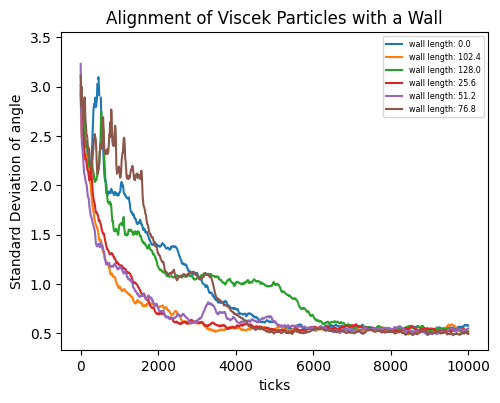

In [6]:
text_width = 5.5
fig_width = text_width
fig_height = 0.75* fig_width
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

lines, wall_lengths = [],[]

iteration = 1
for simulation in simulations[6*iteration:6*(1+iteration)]:
    steps = simulation["steps"]
    alignment_average_frames = simulation["alignment_average"]
    std_angles = np.where(simulation["angle_std"] < 0, np.nan, simulation["angle_std"])

    times = np.arange(0,steps +1, alignment_average_frames)
    line = ax.plot(times, std_angles, label = f"wall length: {simulation["wall length"]:.1f}")
    lines.append(line)
    wall_lengths.append(simulation["wall length"])


# Sort the lines based on wall lengths
sorted_indices = np.argsort(wall_lengths)
sorted_lines = [lines[i] for i in sorted_indices]
sorted_labels = [f"wall length: {wall_lengths[i]:.1f}" for i in sorted_indices]
rho = simulation["rho"]
ax.legend(fontsize = "xx-small")
ax.set_xlabel("ticks")
# ax.set_xlim(-50,5000)
ax.set_ylabel("Standard Deviation of angle")
ax.set_title("Alignment of Viscek Particles with a Wall")
# ax.set_ylim(0)
filename = f"angle_spread_rho={rho}_{steps}.png"
figures_dir = os.getcwd() + "/figures"
filepath = os.path.join(figures_dir, filename)
plt.savefig(filepath, dpi=300, bbox_inches='tight')  # Adjust dpi and bbox_inches as needed
plt.show()

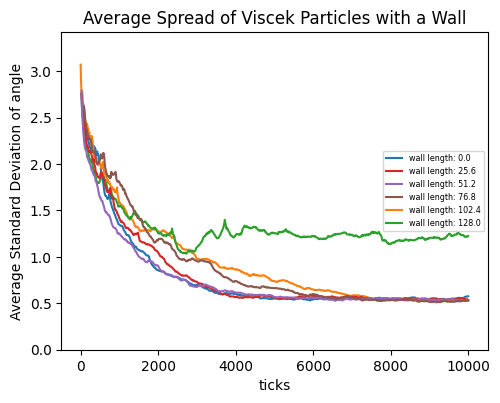

In [7]:
text_width = 5.5
fig_width = text_width
fig_height = 0.75 * fig_width
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Dictionary to store std angles for each wall length
wall_std_dict = {}

# Go through all three iterations
for iteration in [0,1,2,3,4,5]:
    for simulation in simulations[6*iteration:6*(1+iteration)]:
        wall_length = simulation["wall length"]
        steps = simulation["steps"]
        alignment_average_frames = simulation["alignment_average"]
        std_angles = np.where(simulation["angle_std"] < 0, np.nan, simulation["angle_std"])
        times = np.arange(0, steps + 1, alignment_average_frames)
        
        # Initialize list for this wall length if not exists
        if wall_length not in wall_std_dict:
            wall_std_dict[wall_length] = []
        
        # Append the std_angles for this iteration
        wall_std_dict[wall_length].append(std_angles)

# Now calculate average std for each wall length
lines = []
wall_lengths = []

for wall_length, std_list in wall_std_dict.items():
    # Convert to numpy array and calculate mean across iterations
    avg_std = np.mean(std_list, axis=0)
    
    line = ax.plot(times, avg_std, label=f"wall length: {wall_length:.1f}")[0]
    lines.append(line)
    wall_lengths.append(wall_length)

# Sort the lines based on wall lengths
sorted_indices = np.argsort(wall_lengths)
sorted_lines = [lines[i] for i in sorted_indices]
sorted_labels = [f"wall length: {wall_lengths[i]:.1f}" for i in sorted_indices]

rho = simulation["rho"]
ax.legend(sorted_lines, sorted_labels, fontsize="xx-small", loc='center right')
ax.set_xlabel("ticks")
ax.set_ylabel("Average Standard Deviation of angle")
ax.set_title("Average Spread of Viscek Particles with a Wall")
ax.set_ylim(0)

filename = f"average_angle_spread_rho={rho}_{steps}.png"
figures_dir = os.getcwd() + "/figures"
filepath = os.path.join(figures_dir, filename)
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()

In [8]:
wall_lengths = sorted(wall_lengths)

## Comparing different iterations to each other

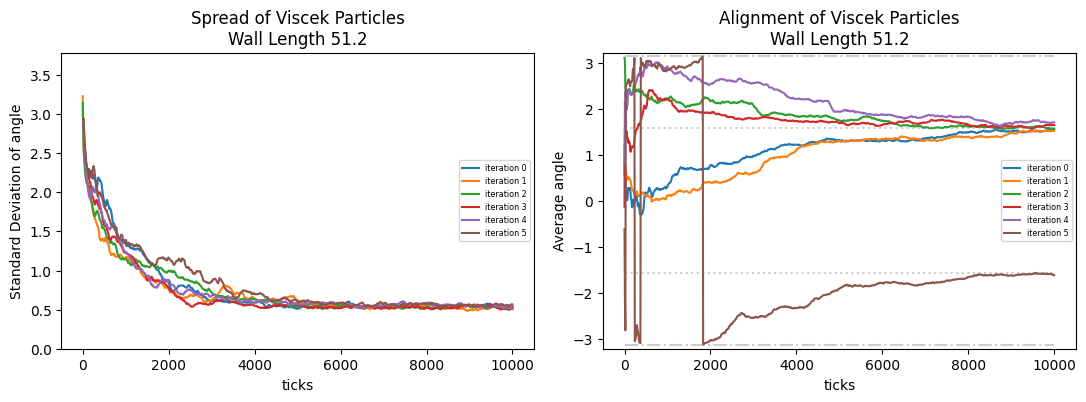

In [12]:
text_width = 5.5
fig_width = text_width
fig_height = 0.75 * fig_width
fig, ax = plt.subplots(ncols=2, figsize=(2*fig_width, fig_height))

wall_length = float(wall_lengths[-4])
for i in range(len(simulations)):
    if simulations[i]["wall length"] == wall_length:
        simulation = simulations[i]
        alignment_average_frames = simulation["alignment_average"]
        
        # Plot standard deviation
        std_angles = np.where(simulation["angle_std"] < 0, np.nan, simulation["angle_std"])
        times = np.arange(0, steps +1, alignment_average_frames)
        ax[0].plot(times, std_angles, label=f"iteration {simulation['iteration']}")
        
        # Plot alignment angle
        angle = simulation["angle"]
        ax[1].plot(times, angle, label=f"iteration {simulation['iteration']}")

rho = simulation["rho"]

# Settings for left plot (spread)
ax[0].legend(fontsize="xx-small", loc='center right')
ax[0].set_xlabel("ticks")
ax[0].set_ylabel("Standard Deviation of angle")
ax[0].set_title(f"Spread of Viscek Particles\nWall Length {wall_length:.1f}")
ax[0].set_ylim(0)

# Settings for right plot (alignment)
ax[1].legend(fontsize="xx-small", loc='center right')
ax[1].set_xlabel("ticks")
ax[1].set_ylabel("Average angle")
ax[1].set_title(f"Alignment of Viscek Particles\nWall Length {wall_length:.1f}")
ax[1].set_ylim(-3.22, 3.22)

# Add the horizontal lines for angle limits
ax[1].plot([0,times.max()],[-np.pi, -np.pi], linestyle="-.", color="grey", alpha=0.4)  # Lower angle limit
ax[1].plot([0,times.max()],[np.pi, np.pi], linestyle="-.", color="grey", alpha=0.4)    # Upper angle limit
ax[1].plot([0,times.max()],[np.pi/2, np.pi/2], linestyle="dotted", color="grey", alpha=0.4)  # Upper angle limit
ax[1].plot([0,times.max()],[-np.pi/2, -np.pi/2], linestyle="dotted", color="grey", alpha=0.4)  # Upper angle limit

plt.tight_layout()  # Adjust spacing between subplots

filename = f"max_wall_length_spread_and_alignment_rho={rho}_{steps}.png"
figures_dir = os.getcwd() + "/figures"
filepath = os.path.join(figures_dir, filename)
# plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()